In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(0,'..')

import matplotlib.pyplot as plt
import os.path
import prepare
import seaborn as sns

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, \
                            classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(16,10))
plt.rc('font', size=14)
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', 50)

In [2]:
if os.path.isfile('sso_dict.csv'):
    df_dict = pd.read_csv('sso_dict.csv')
else:
    url_sso_dict = '''https://storage.googleapis.com/sa_saws_data/SAWS_SSO_DataFieldDescription_MM.xlsx'''
    df_dict = pd.read_excel(url_sso_dict)
    df_dict.to_csv('sso_dict.csv', index=False)

In [3]:
df_dict

,Field,Data Description
0,SSO_ID,Internal ID
1,INSPKEY,Not Used
2,SERVNO,Service Req # (internal use only)
3,REPORTDATE,Date Reported
4,SPILL_ADDRESS,Street number of spill
5,SPILL_ST_NAME,Streen name of spill
6,TOTAL_GAL,Total gallons spilled
7,GALSRET,Gallons returned to collection system
8,GAL,Disregard
9,SPILL_START,When SAWS received information about the spill or arrived at the location


In [4]:
# df = acquire_sso.acquire_sso()

In [5]:
# df.head(1)

In [6]:
# df = prepare_sso.prepare_sso_df()
# df.head(1)

In [7]:
# df = prepare.prepare_sso_df()
# print(df.shape[0])
# df.head(1)

In [8]:
# df.columns = ['sso_id','report_date','spill_address_num','spill_st_name',
#  'total_gal','gals_ret','spill_start','spill_stop','hrs','cause',
#  'comments','actions','watershed','unit_id','unit_id2','discharge_to',
#  'discharge_route','council_district','month','year','week',
#  'earz_zone','pipe_diam','pipe_len','pipe_type','inst_year','inches_no',
#  'rainfall_last3','spill_address_full','num_spills_recorded',
#  'num_spills_24mos','prevspill_24mos','unit_type','asset_type',
#  'last_cleaned','response_time','response_dttm','public_notice',
#  'root_cause','hrs_2','gal_2','hrs_3','gal_3','days_since_cleaned']

In [9]:
# df.head(1)

In [10]:
# df.ResponseTime * 60

In [11]:
# df.shape

In [12]:
# df_dict.shape

In [13]:
# df_dict['Data Description'].value_counts()

In [14]:
# unused = ['Disregard','Ignore','Service Req # (internal use only)',
#           'Not Used','Old mapping system reference (internal only)']
# df_dict[df_dict['Data Description'].isin(unused)]

In [15]:
# ready1_dict = df_dict[~df_dict['Data Description'].isin(unused)]
# print(len(ready1_dict))
# ready1_dict

In [16]:
# null_fields = ['SPILL_START_2','SPILL_START_3',
#                'SPILL_STOP_2','SPILL_STOP_3']
# final_dict = ready1_dict[~ready1_dict.Field.isin(null_fields)]\
#                     .reset_index(drop=True)
# len(final_dict)

In [17]:
# final_dict

In [18]:
# features_to_use = list(final_dict.Field)
# len(features_to_use)

In [19]:
# bad_features = list(df.columns[~df.columns.isin(features_to_use)])

In [20]:
# df = df.drop(columns=bad_features)
# df = df.drop(columns = ['TIMEINT','STEPS_TO_PREVENT'])
# df.shape

In [21]:
# string_features = ['SSO_ID','SPILL_ADDRESS','COUNCIL_DISTRICT',]
# for col in string_features:
#     df[col] = df[col].astype(str)
    
# time_features = ['REPORTDATE','SPILL_START','SPILL_STOP',
#                  'ResponseDTTM', 'LASTCLND']
# for col in time_features:
#     df[col] = pd.to_datetime(df[col])
    
# fill_features = ['NUM_SPILLS_24MOS','PREVSPILL_24MOS','HRS_2',
#                 'HRS_3','GAL_2','GAL_3']
# for col in fill_features:
#     df[col] = df[col].fillna(0)
    
# df.Root_Cause = df.Root_Cause.str.strip()

In [22]:
# df['days_since_cleaned'] = (df.SPILL_START - df.LASTCLND).dt.days

In [23]:
# df['country_address'] = df.spill_address_full + \
#                                   ',SAN ANTONIO,Texas,USA'
# df.country_address

In [24]:
# df[['country_address']].head(25)

In [25]:
# for i in range(df.index.max()//5):
#     print([1*i+5, 2*i+5, 3*i + 5])

In [26]:
# lmo = pd.DataFrame()
# lmo['loc'] = ['string','fnish']
# lmo['was'] = [2,3]
# lmo.was[1] = 4
# lmo

In [27]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)
# test2 = pd.Series()

# counter = 10
# for i in range(0, df.index.max(), 10):
#     test = df[['country_address']][i:counter]
#     test['location'] = test['country_address'].apply(geocode)
#     test['zip_code'] = 'None'
#     for t,l in enumerate(test.location):
#         if l is not None:
#             test['zip_code'][counter+t-10] = l.raw['display_name']\
#                                     .split(',')[-2]
#     time.sleep(2)
#     test2 = test2.append(test.zip_code)
#     counter+=10
# test2

### Working

In [28]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1, 
#                      max_retries=10, error_wait_seconds=1)
# df['location'] = df['country_address'].apply(geocode)
# df['zip_code'] = 'None'

In [29]:
# for t,l in enumerate(df.location):
#         if l is not None:
#             df['zip_code'][t] = l.raw['display_name']\
#                                     .split(',')[-2]

In [30]:
# df = prepare.prepare_sso_with_zipcodes()
# print(df.shape[0])
# df.head(1)

# Exploration

In [31]:
df = prepare.get_data()
print(df.shape)
df.head(1)

(3183, 75)


,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
0,6582,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2019-03-10 13:16:00,2019-03-10 14:40:00,1.4,Grease,"Spill ContainedReturned to SystemArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,3,2019,11,0,8.0,16.55,PVC,...,1.4,0.0,0.0,0.0,69.0,79,60,1,1,0,0,0,0,0.004286,0.005714,0.016333,54.285714,55.285714,54.2,65.857143,65.714286,64.533333,46.0,47.642857,45.9


In [32]:
df.root_cause.isna().sum()

0

In [33]:
df.root_cause.value_counts(dropna=False)

structural           1237
grease                611
debris                444
rain event            401
contractor            172
lift station          140
vandalism              72
other                  69
roots                  22
i/i                    12
by pass pump leak       3
Name: root_cause, dtype: int64

In [34]:
train, test = train_test_split(df, random_state=42, train_size=.8,
                              stratify=df.root_cause)

In [35]:
train.zip_code.value_counts().head(5)

None     754
Texas    231
78228     93
78223     84
78209     76
Name: zip_code, dtype: int64

In [36]:
train.isna().sum()

sso_id                 0
report_date            0
spill_address_num      0
spill_st_name          0
total_gal              0
                      ..
max_temp_rolling_14    0
max_temp_rolling_30    0
min_temp_rolling_7     0
min_temp_rolling_14    0
min_temp_rolling_30    0
Length: 75, dtype: int64

In [37]:
train.spill_address_full.head(15)

434     11780 Parliament  Over The Edwards Aquifer Transition Zone
871                                                1830 LENNON AVE
2175                                                5500 Cagnon Rd
1588                                             1910 Catalina Ave
724                                                  YOLANDA 00111
10                                                  5 Trophy Ridge
219                                                      2600 CIMA
2327                               3440 Fredericksburg Rd In Front
207                                               515 Woodcrest Dr
1438                                                    210 Tuleta
3                                              3602 SE MILITARY DR
284                                             1900 Blue Crest Ln
1631                6931 Alan Hale Dr  ( Into Dry Zarzamora Creek)
601                                                    139 Prelude
348                                                  111 DALLA

In [38]:
train.days_since_cleaned.dropna()

434     164.0
871     164.0
2175    164.0
1588    164.0
724     164.0
        ...  
613     164.0
2123    169.0
1955    371.0
1201      0.0
2497     34.0
Name: days_since_cleaned, Length: 2546, dtype: float64

In [39]:
train[train.days_since_cleaned == train.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0,8.0,400.0,VCP,...,1.3,0.0,0.0,0.0,39.0,41,32,0,0,0,0,0,0,1.055703e-16,0.005714,0.022333,53.857143,57.214286,56.2,65.0,68.142857,67.433333,42.571429,45.357143,45.233333


In [40]:
features = df.isna().sum() / df.shape[0]
bad_list = features[features > .4]
print(len(bad_list))
bad_list

3


last_cleaned     0.654100
response_time    0.607603
response_dttm    0.607603
dtype: float64

In [41]:
train.drop(columns='hours_spilled')\
    .describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,sso_id,spill_address_num,total_gal,gals_ret,hrs,council_district,month,year,week,pipe_diam,pipe_len,inches_no,rainfall_last3,num_spills_recorded,num_spills_24mos,response_time,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,age,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
count,2546.000000,2546.000000,2546.000000,2178.000000,2543.000000,2288.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2158.000000,2117.000000,2546.000000,2546.000000,1018.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000
mean,3341.567557,4285.021603,31895.417125,3047.653811,4.432720,5.003059,6.272977,2012.937549,25.993716,11.184014,285.649892,0.471979,0.499655,1.925373,0.730558,-281.670923,0.239017,3789.840141,0.027503,187.827965,197.075412,36.878633,0.415373,0.001218,0.000786,68.522781,79.120974,58.458759,0.385703,0.043205,0.162608,0.083661,0.011783,0.166143,0.183623,0.143606,0.119295,68.781702,68.899057,68.936207,79.489115,79.692852,79.804569,58.693244,58.740882,58.691307
std,1890.664846,4632.791262,223165.355712,55579.479139,40.662691,3.068449,3.587650,2.962441,15.619165,10.001582,430.682510,1.310179,1.029894,2.136209,1.166521,10033.429465,2.919121,62384.538180,0.505360,5421.000616,180.972289,21.084762,1.226946,0.040070,0.039637,13.493754,13.876564,14.469508,0.486857,0.203358,0.369080,0.276933,0.107930,0.372282,0.302246,0.183799,0.111148,12.926202,12.699947,12.470677,13.022915,12.763675,12.497217,13.574862,13.250989,12.943708
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-319950.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,24.000000,29.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.285714,42.178571,46.466667,47.142857,50.000000,55.333333,25.000000,26.642857,33.700000
25%,2106.250000,700.000000,50.000000,0.000000,0.750000,2.000000,3.000000,2010.000000,12.000000,8.000000,145.025000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,164.000000,22.250000,0.000000,0.000000,0.000000,59.000000,70.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010714,0.031667,57.857143,57.500000,56.950000,69.714286,69.285714,68.900000,46.607143,46.428571,46.500000
50%,2913.500000,2600.000000,249.500000,0.000000,1.416667,5.000000,6.000000,2012.000000,24.000000,8.000000,264.500000,0.000000,0.000000,1.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,164.000000,37.000000,0.000000,0.000000,0.000000,70.500000,80.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034286,0.067143,0.088667,69.928571,69.714286,70.058333,80.285714,80.500000,80.666667,59.714286,59.571429,59.116667
75%,5791.500000,6785.000000,2350.000000,0.000000,2.816667,8.000000,9.000000,2016.000000,40.000000,8.000000,350.000000,0.090000,0.460000,2.000000,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,164.000000,50.000000,0.050000,0.000000,0.000000,79.500000,89.000000,71.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249286,0.226429,0.170000,79.785714,80.116071,79.966667,89.857143,90.071429,90.566667,71.714286,71.428571,70.866667
max,6584.000000,28194.000000,6026731.000000,2385150.000000,1796.000000,10.000000,12.000000,2019.000000,53.000000,66.000000,11689.350000,9.870000,12.200

In [42]:
len(train.report_date.unique())

1620

In [43]:
train[train.num_spills_recorded == train.num_spills_recorded.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
71,6512,2018-11-13,606,N ALAMO ST,2080,0.0,2018-11-13 08:16:00,2018-11-13 10:00:00,1.733333,Contractor,NaN,REMOVED BYPASS,DOS RIOS,STMDRAIN,NaN,STORMDRAIN - Then entered the San Antonio River,SAN ANTONIO RIVER,NaN,11,2018,46,0,8.0,264.5,unknown,...,1.733333,0.0,0.0,0.0,40.0,48,28,0,0,0,0,0,0,2.300000e-01,0.182857,0.202667,55.428571,60.214286,60.866667,59.857143,67.642857,69.166667,47.714286,51.000000,52.866667
716,5863,2016-04-23,4006,BRIARGLEN,6000,NaN,2016-04-22 21:00:00,2016-04-22 23:00:00,2.000000,Other,NaN,REPAIRED PUMP,SALADO CREEK,46429,46423,CREEK BED - SPILLED INTO BEITEL CREEK,BEITEL CREEK,NaN,4,2016,17,0,8.0,264.5,unknown,...,2.000000,0.0,0.0,0.0,70.0,81,56,0,0,0,0,0,0,3.785714e-01,0.358571,0.172667,71.428571,70.142857,67.300000,80.428571,79.642857,78.000000,62.714286,62.285714,56.866667
800,5774,2015-12-22,5704,PRESA ST S,90,NaN,2015-12-21 11:16:00,2015-12-21 18:00:00,6.733333,Structural,"Repaired main, 10"" sewer main",REPAIRED MAIN,DOS RIOS,NaN,NaN,DRAINAGE CULVERT,NONE,3.0,12,2015,52,0,8.0,264.5,unknown,...,6.733333,0.0,0.0,0.0,62.0,79,48,0,0,0,0,0,0,3.172066e-16,0.052857,0.102333,56.857143,60.285714,57.666667,69.142857,72.928571,69.466667,43.857143,47.571429,46.000000


In [44]:
train[train.total_gal.isin(list(train.total_gal.nlargest(8)))]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
2338,18,2010-10-20,8600,MISSION PKWY,4442000,NaN,2010-10-20 09:00:00,2010-10-27 11:00:00,170.00,Break In Main,REPAIRED FORCE MAIN - L/S # 172,REPAIRED BROKEN MAIN,DOS RIOS,13440,14063,CREEK BED,SAN ANTONIO RIVER,3.0,10,2010,43,0,30.0,122.58,FRP,...,170.000000,0.00,0.0,0.0,74.0,85,63,0,0,0,0,0,0,0.000000,0.006429,0.017667,69.857143,70.285714,72.083333,82.857143,83.428571,84.200000,56.857143,57.142857,59.966667
2771,1796,2010-01-15,300,PETALUMA BLVD E,3570000,NaN,2010-01-15 02:00:00,2010-01-16 03:00:00,25.00,I/I,"ADDED 18"" BY PASS",ADDED BY PASS,DOS RIOS,16451,20815,CREEK BED,SIX MILE CREEK,3.0,1,2010,3,0,36.0,1005.00,RCP,...,25.000000,1.81,0.0,0.0,51.0,56,46,1,0,0,1,0,1,0.511429,0.255714,0.150667,45.500000,43.500000,46.900000,55.000000,52.785714,57.133333,36.000000,34.214286,36.666667
647,5943,2016-06-02,6606,SWISS OAKS,2050500,0.0,2016-06-02 11:45:00,2016-06-06 12:30:00,96.75,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,903064,903061,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,6.0,6,2016,23,0,0.0,16.81,,...,96.750000,2.34,0.0,0.0,74.0,85,66,1,0,1,0,0,0,0.941429,0.471429,0.382333,77.285714,77.500000,75.166667,88.000000,87.071429,84.566667,67.285714,69.928571,67.100000
84,6499,2018-10-24,108,CHAPPIE JAMES WAY,2448400,0.0,2018-10-24 13:50:00,2018-10-28 13:29:00,95.65,I/I,NaN,MONITORED AREA,LEON CREEK,1210,42319,CREEK BED - Spilled Into Leon Creek,LEON CREEK,NaN,10,2018,43,0,54.0,1335.00,RCP,...,95.650000,0.79,0.0,0.0,59.0,63,55,1,0,0,0,0,0,0.282857,0.254286,0.185333,60.000000,62.928571,70.533333,65.571429,70.000000,78.100000,55.428571,57.428571,64.700000
688,5888,2016-05-18,700,HOLBROOK,2754790,0.0,2016-05-17 18:28:00,2016-05-21 03:00:00,80.53,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,990827,48236,CREEK BED - Spilled Into Salado Creek,SALADO CREEK,2.0,5,2016,21,0,0.0,0.00,,...,80.533333,0.14,0.0,0.0,71.0,78,63,0,0,1,0,0,0,0.292857,0.214286,0.155333,73.285714,73.928571,73.000000,79.857143,82.500000,82.466667,67.000000,65.714286,63.666667
504,6062,2016-12-03,108,CHAPPIE JAMES WAY,1880100,0.0,2016-12-03 09:24:00,2016-12-04 09:00:00,23.60,I/I,NaN,Diluted By Heavy Rain Water,LEON CREEK,462766,1210,CREEK BED - Spilled Into Leon Creek,LEON CREEK,0.0,12,2016,49,0,54.0,17.18,CSC,...,23.600000,3.84,0.0,0.0,53.0,53,50,1,0,1,0,0,0,0.642857,0.321429,0.207667,60.857143,60.785714,63.833333,70.142857,71.642857,73.933333,49.285714,49.500000,53.933333
646,5942,2016-06-02,700,HOLBROOK,6026731,0.0,2016-06-02 11:09:00,2016-06-06 07:30:00,92.35,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,47822,922726,CREEK BED - SPILLED INTO SALADO CREEK,SALADO CREEK,2.0,6,2016,23,0,0.0,5.89,,...,92.350000,2.34,0.0,0.0,74.0,85,66,1,0,1,0,0,0,0.941429,0.471429,0.382333,77.285714,77.500000,75.166667,88.000000,87.071429,84.566667,67.285714,69.928571,67.100000
653,5922,2016-05-31,108,CHAPPIE JAMES WAY,2453340,0.0,2016-05-31 17:08:00,2016-06-01 07:02:00,13.90,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,1187,1074,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,NaN,5,2016,23,0,54.0,17.61,CSC,...,13.900000,1.84,0.0,0.0,77.0,85,67,1,0,1,0,0,0,0.607143,0.447857,0.304333,79.285714,76.714286,74.633333,89.142857,85.928571,83.866667,70.285714,69.285714,66.466667


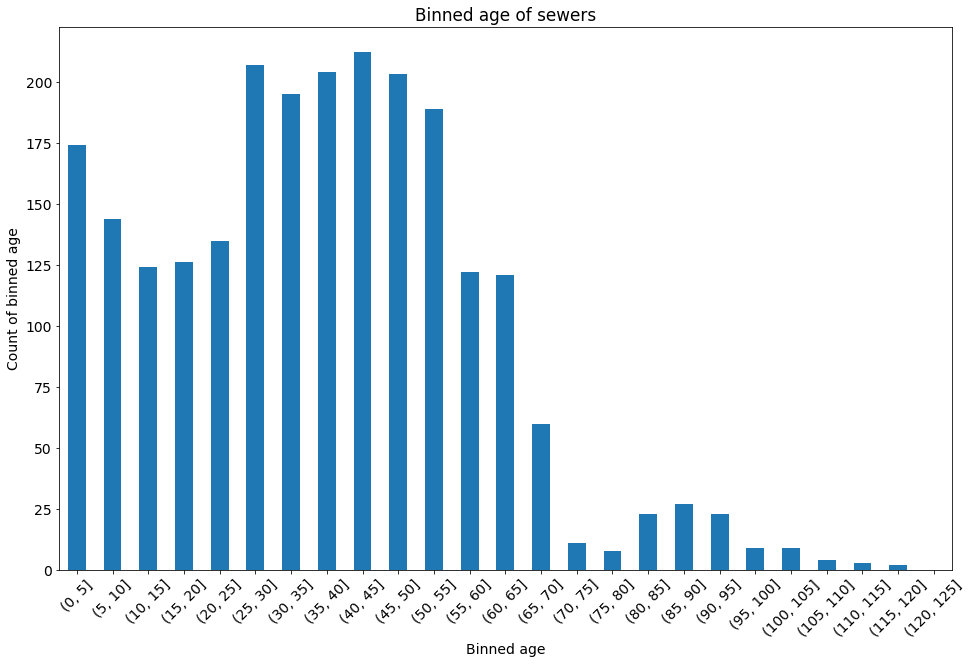

In [45]:
train.age_binned.dropna().value_counts().sort_index().plot.bar()
plt.xticks(rotation=45)

plt.ylabel('Count of binned age')
plt.xlabel('Binned age')
plt.title('Binned age of sewers')
plt.show()

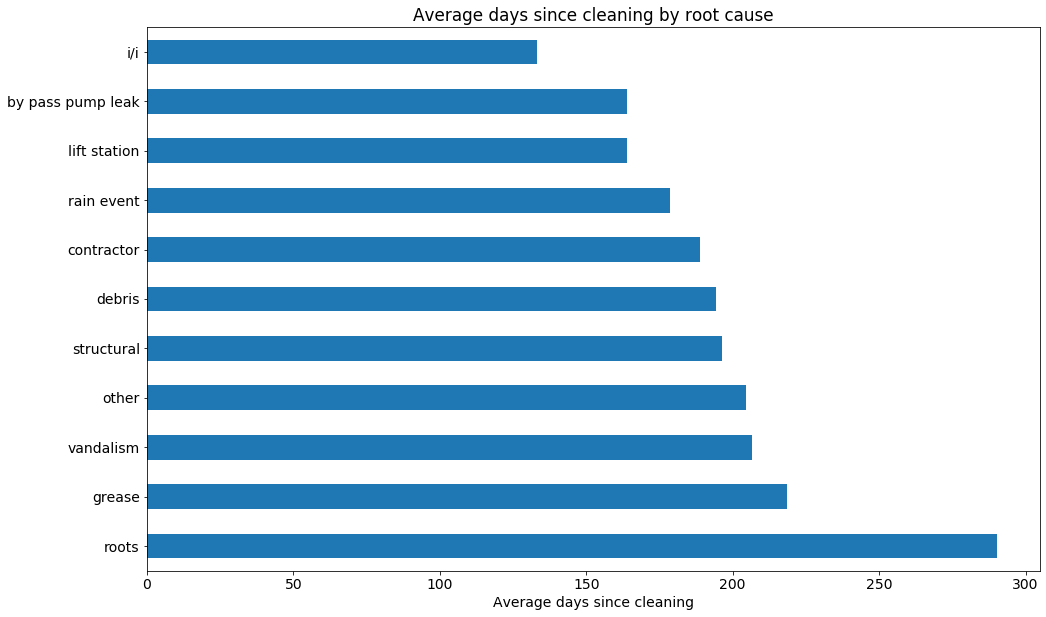

In [46]:
ax = train.groupby('root_cause').days_since_cleaned.mean()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Average days since cleaning')
plt.title('Average days since cleaning by root cause')
plt.show()

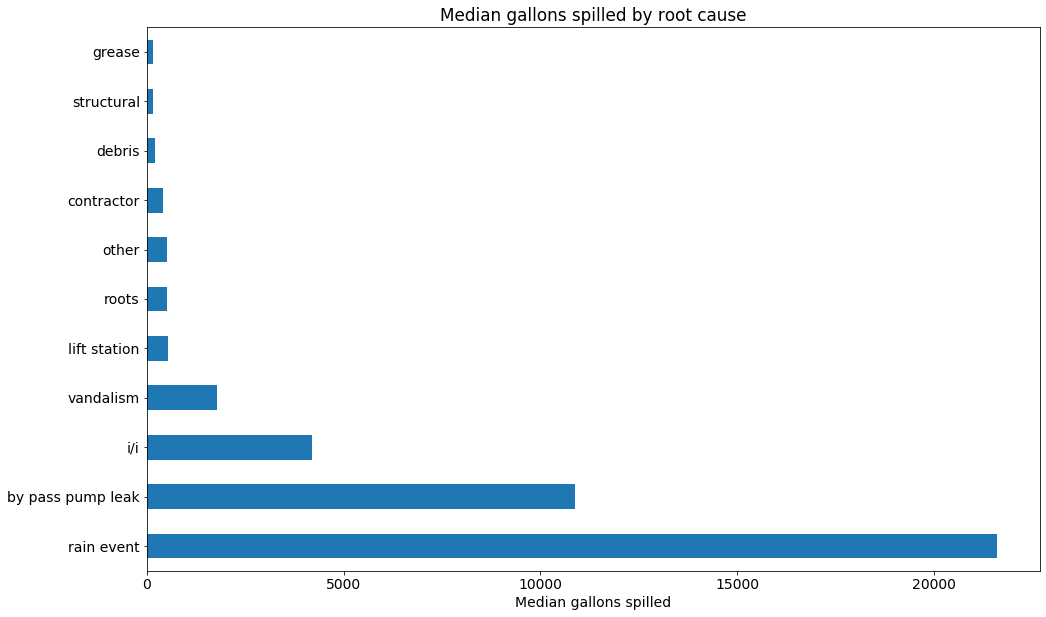

In [47]:
ax = train.groupby('root_cause').total_gal.median()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Median gallons spilled')
plt.title('Median gallons spilled by root cause')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

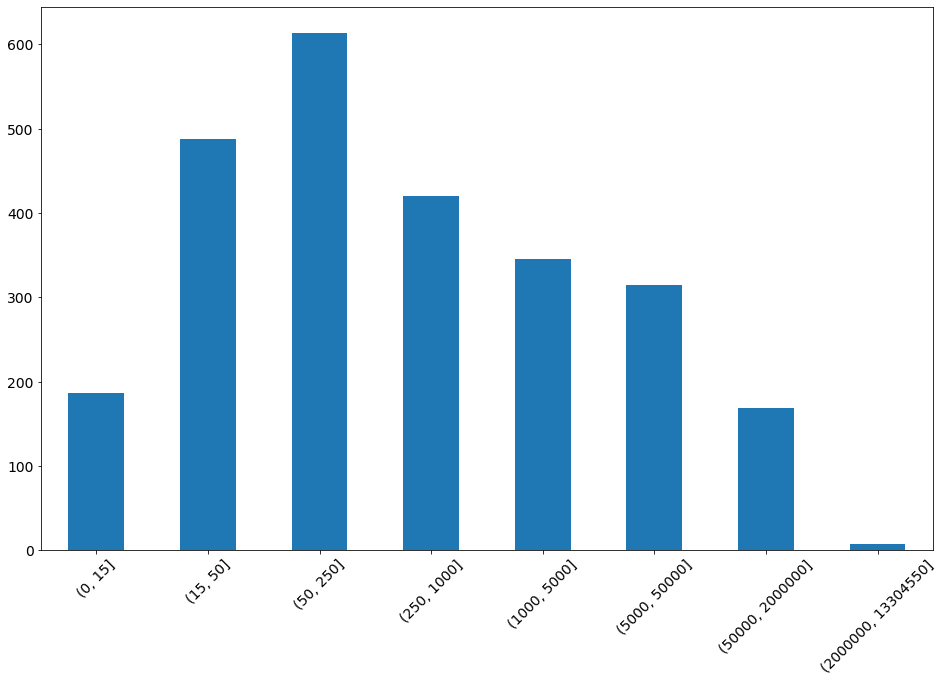

In [48]:
train['total_gal_binned'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=45)

In [49]:
train[train.days_since_cleaned == train.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0,8.0,400.0,VCP,...,1.3,0.0,0.0,0.0,39.0,41,32,0,0,0,0,0,0,1.055703e-16,0.005714,0.022333,53.857143,57.214286,56.2,65.0,68.142857,67.433333,42.571429,45.357143,45.233333


In [50]:
train[train.inst_year == train.inst_year.max()].shape

(106, 75)

In [51]:
df.zip_code.value_counts()

None     945
Texas    288
78228    124
78223    108
78209     93
        ... 
78109      1
79107      1
78628      1
78355      1
75930      1
Name: zip_code, Length: 219, dtype: int64

In [52]:
df.inches_no.isna().sum()

487

In [53]:
df[df.age=='unknown'].shape

(0, 75)

In [54]:
df.age = df.age.replace('unknown', 0)
df.age = df.age.replace(0, df.age.median())

In [55]:
df.age

0       22.0
1       31.0
2       64.0
3       36.0
4       67.0
        ... 
3178    43.0
3179    33.0
3180    51.0
3181    37.0
3182    52.0
Name: age, Length: 3183, dtype: float64

In [56]:
df.pipe_len.isna().sum()

0

In [57]:
df.pipe_diam.isna().sum()

0

In [58]:
df.days_since_cleaned.median()

164.0

In [59]:
df[df.zip_code=='78245'].root_cause.value_counts()

lift station    14
structural       8
debris           8
grease           8
contractor       6
other            2
rain event       1
vandalism        1
Name: root_cause, dtype: int64

In [60]:
root_cause_zipcode = df.groupby('zip_code').root_cause.apply(
        lambda x: x.value_counts().head(1))
# root_cause_zipcode.to_csv('root_cause_zipcode.csv')
root_cause_zipcode.sort_values().tail(40)

zip_code              
77640     structural        5
78214     grease            6
78250     grease            6
78253     contractor        6
78241     structural        6
78226     structural        7
78521     rain event        7
78612     lift station      7
78203     grease            7
78225     structural        8
78224     debris            8
78202     structural        8
78237     grease            9
78251     debris            9
78208     structural        9
78238     structural       10
78247     structural       11
78221     structural       13
78240     structural       14
78245     lift station     14
78233     grease           15
78211     structural       16
78220     structural       16
78229     structural       16
38012     structural       18
78217     structural       20
78210     structural       22
78207     structural       23
78216     structural       24
78213     structural       28
78242     rain event       28
78212     structural       28
78227     structu

In [61]:
train.pipe_type.value_counts()

PVC         760
VCP         743
CT          223
HDPE        172
unknown     153
CP          150
RCP         128
CAS          56
DIP          48
             37
RL           32
FRP          21
CSC          10
XXX           6
AC            3
SMARTLID      2
PICK BAR      1
BR            1
Name: pipe_type, dtype: int64

In [62]:
train.groupby('age_binned').total_gal.median()\
    .sort_values(ascending=False)

age_binned
(115, 120]    4375.0
(110, 115]    3000.0
(10, 15]      1395.0
(40, 45]      1000.0
(30, 35]       500.0
(35, 40]       500.0
(95, 100]      450.0
(105, 110]     390.0
(5, 10]        390.0
(25, 30]       390.0
(15, 20]       300.0
(65, 70]       250.5
(0, 5]         250.0
(50, 55]       200.0
(70, 75]       200.0
(20, 25]       200.0
(45, 50]       195.0
(75, 80]       175.0
(55, 60]       145.0
(60, 65]       100.0
(85, 90]       100.0
(90, 95]       100.0
(100, 105]     100.0
(80, 85]        50.0
(120, 125]       NaN
Name: total_gal, dtype: float64

In [63]:
train.root_cause.value_counts()

structural           989
grease               489
debris               355
rain event           321
contractor           137
lift station         112
vandalism             58
other                 55
roots                 18
i/i                   10
by pass pump leak      2
Name: root_cause, dtype: int64

In [64]:
train.head(1)

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
434,6144,2017-03-31,11780,PARLIAMENT,6100,0.0,2017-03-31 09:58:00,2017-03-31 12:00:00,2.033333,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,SALADO CREEK,67605,53038,STORMDRAIN - Over The Edwards Aquifer Transition Zone,None,9.0,3,2017,13,0,8.0,281.0,PVC,...,2.033333,0.0,0.0,0.0,69.0,86,52,0,0,0,0,0,0,0.124286,0.062143,0.069667,71.142857,71.142857,66.833333,83.571429,82.785714,77.0,59.285714,60.642857,58.166667


In [65]:
train[train.root_cause == 'other']['cause'].value_counts()

Other                                                   13
Grease                                                   9
Debris                                                   8
Other - Capacity                                         5
Structural                                               4
Plug In Main                                             4
By-pass Pump Failure                                     2
I/I                                                      2
By-Pass Equip Failure                                    2
Other - Spill Was Caused By A Surcharging Sewer Main     1
Human Error                                              1
Other - Cause To Be Determined                           1
Contractor                                               1
By-Pass Pump Failure                                     1
Broken ARV                                               1
Name: cause, dtype: int64

In [66]:
top_worst_spills = train[train.total_gal.isin(
                            train.total_gal.nlargest(15))]
top_worst_spills[['age_binned','total_gal']]\
    .sort_values('total_gal', ascending=False)

,age_binned,total_gal
646,"(40.0, 45.0]",6026731
2338,"(15.0, 20.0]",4442000
2771,"(60.0, 65.0]",3570000
688,"(0.0, 5.0]",2754790
653,"(30.0, 35.0]",2453340
84,"(50.0, 55.0]",2448400
647,"(0.0, 5.0]",2050500
504,"(30.0, 35.0]",1880100
112,"(50.0, 55.0]",1640538
695,"(30.0, 35.0]",1527175


In [67]:
top_bins = top_worst_spills.sort_values(by='total_gal', 
                        ).age_binned.value_counts()
top_bins[top_bins>0]

(0, 5]      4
(50, 55]    3
(30, 35]    3
(40, 45]    2
(15, 20]    1
(60, 65]    1
Name: age_binned, dtype: int64

In [68]:
train.groupby('age_binned').total_gal.mean()\
            .dropna().sort_values().tail(6)

age_binned
(60, 65]     32023.148760
(15, 20]     42206.603175
(30, 35]     56013.994872
(50, 55]     56520.216931
(0, 5]       63933.298851
(40, 45]    103412.000000
Name: total_gal, dtype: float64

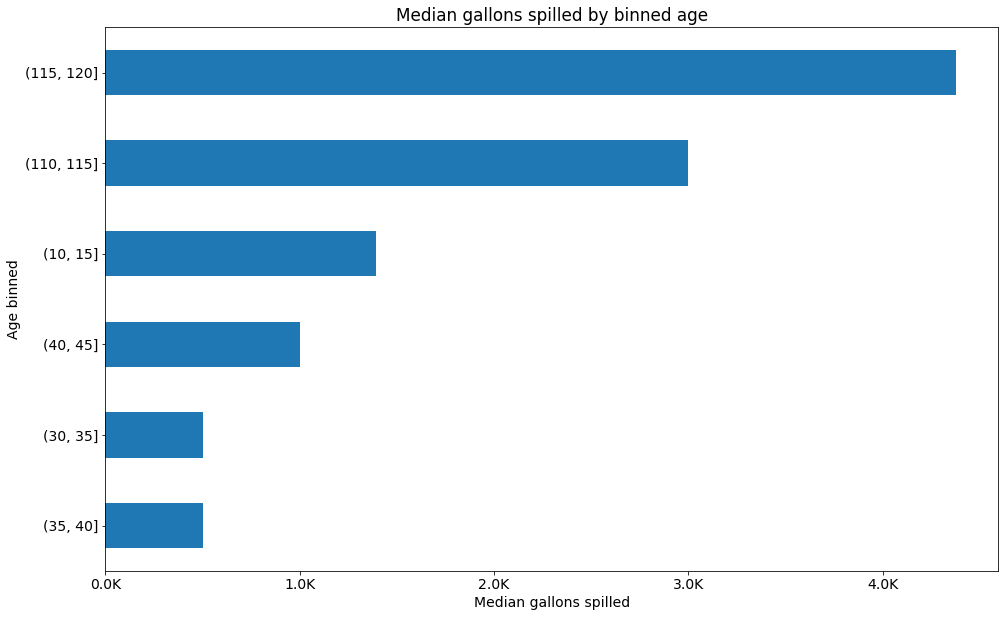

In [69]:
ax = train.groupby('age_binned').total_gal.median()\
            .dropna().sort_values().tail(6).plot.barh()
xlabels = ['{:,.1f}'.format(x) +'K' 
                   for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
ax.set_xlabel('Median gallons spilled')
ax.set_ylabel('Age binned')
plt.title('Median gallons spilled by binned age')
plt.show()

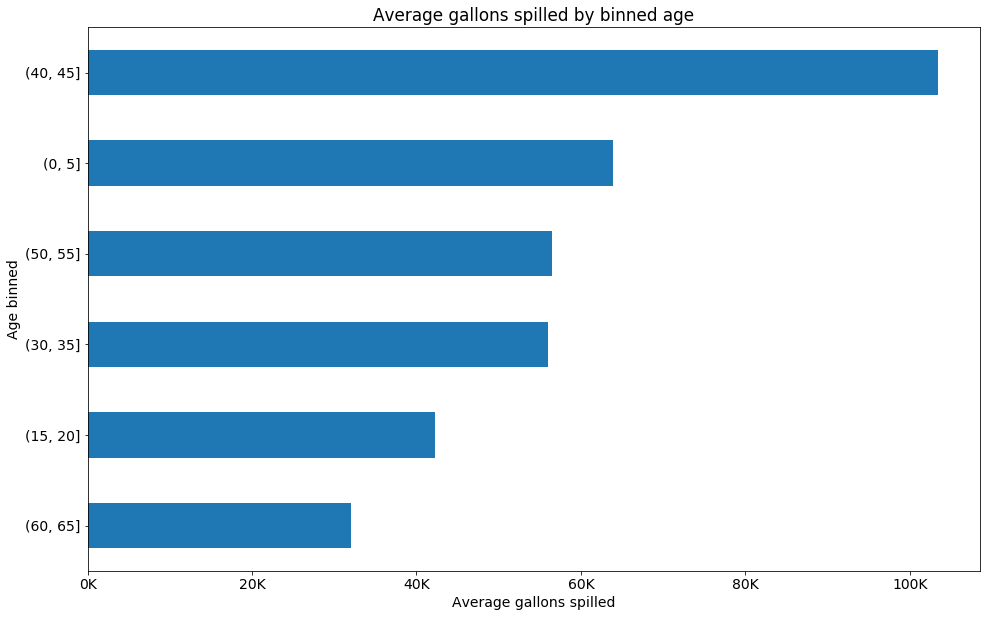

In [70]:
ax = train.groupby('age_binned').total_gal.mean()\
            .dropna().sort_values().tail(6).plot.barh()
xlabels = ['{:,.0f}'.format(x) +'K' 
                   for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
ax.set_xlabel('Average gallons spilled')
ax.set_ylabel('Age binned')
plt.title('Average gallons spilled by binned age')
plt.show()

In [71]:
# num_spills_recorded, num_spills_24mos

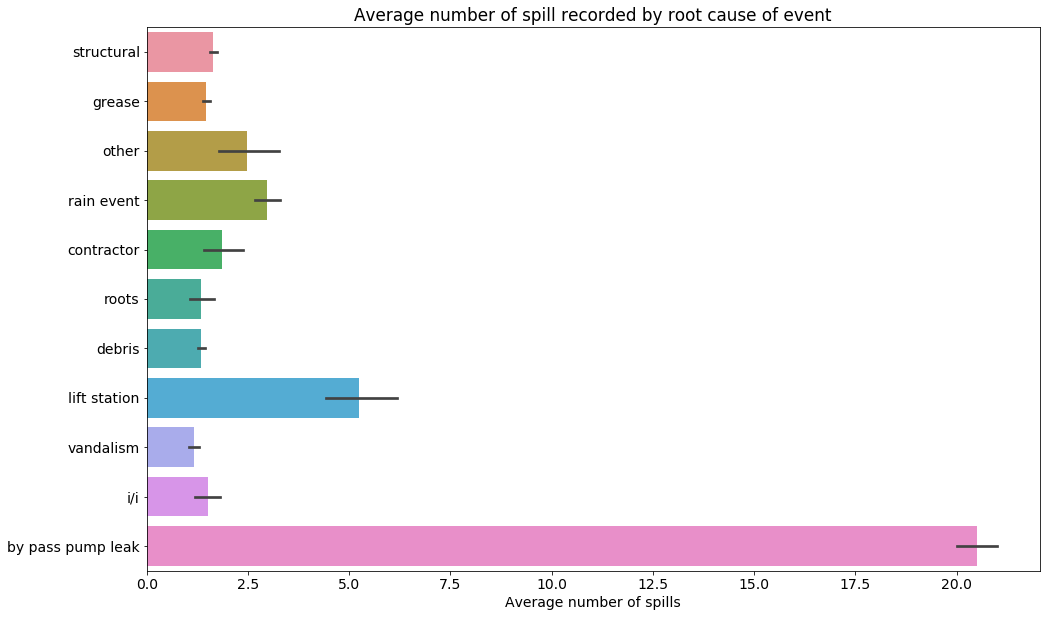

In [72]:
sns.barplot(train.num_spills_recorded, train.root_cause)
plt.xlabel('Average number of spills')
plt.ylabel('')
plt.title('Average number of spill recorded by root cause of event')
plt.show()

In [73]:
# train.groupby('root_cause').num_spills_24mos.sum()
df.root_cause.value_counts()

structural           1237
grease                611
debris                444
rain event            401
contractor            172
lift station          140
vandalism              72
other                  69
roots                  22
i/i                    12
by pass pump leak       3
Name: root_cause, dtype: int64

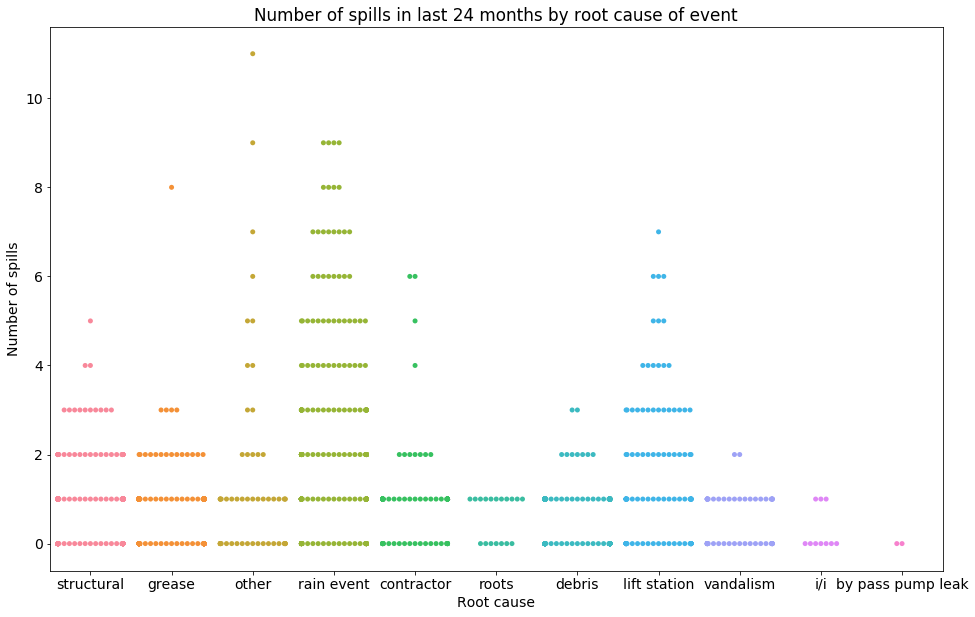

In [74]:
sns.swarmplot(train.root_cause, train.num_spills_24mos)
plt.xlabel('Root cause')
plt.ylabel('Number of spills')
plt.title(
'Number of spills in last 24 months by root cause of event')
plt.show()

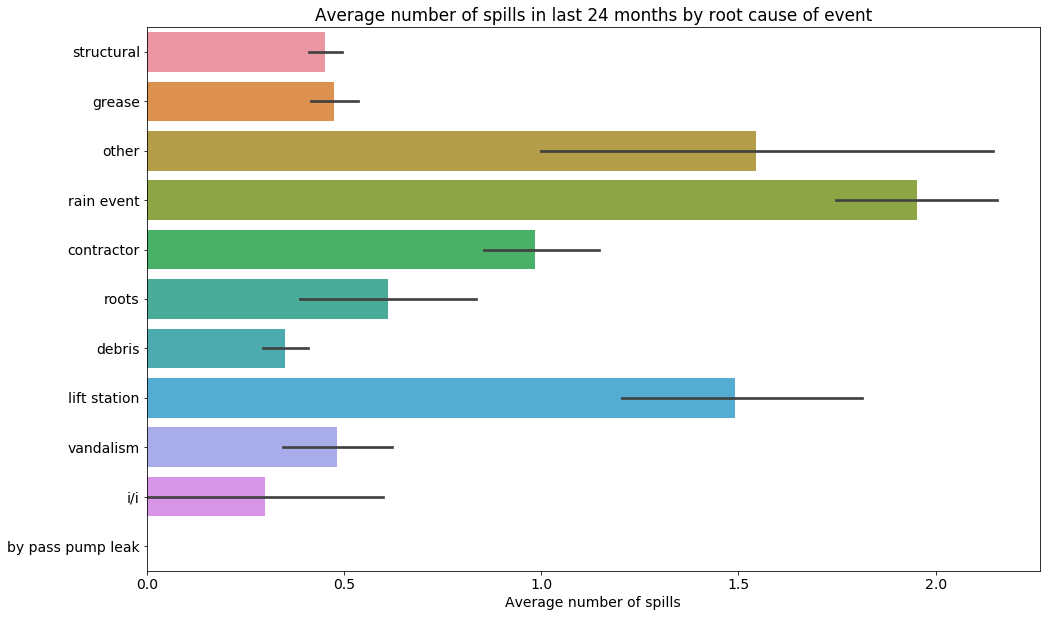

In [75]:
sns.barplot(train.num_spills_24mos, train.root_cause)
plt.xlabel('Average number of spills')
plt.ylabel('')
plt.title(
'Average number of spills in last 24 months by root cause of event')
plt.show()

In [76]:
df.to_csv('cleaned_df.csv')

## Make data useable for modeling

In [77]:
list(df.columns)

['sso_id',
 'report_date',
 'spill_address_num',
 'spill_st_name',
 'total_gal',
 'gals_ret',
 'spill_start',
 'spill_stop',
 'hrs',
 'cause',
 'comments',
 'actions',
 'watershed',
 'unit_id',
 'unit_id2',
 'discharge_to',
 'discharge_route',
 'council_district',
 'month',
 'year',
 'week',
 'earz_zone',
 'pipe_diam',
 'pipe_len',
 'pipe_type',
 'inst_year',
 'inches_no',
 'rainfall_last3',
 'spill_address_full',
 'num_spills_recorded',
 'num_spills_24mos',
 'prevspill_24mos',
 'unit_type',
 'asset_type',
 'last_cleaned',
 'response_time',
 'response_dttm',
 'public_notice',
 'root_cause',
 'hrs_2',
 'gal_2',
 'hrs_3',
 'gal_3',
 'days_since_cleaned',
 'total_gal_binned',
 'country_address',
 'location',
 'zip_code',
 'age',
 'age_binned',
 'hours_spilled',
 'precipitation',
 'snowfall',
 'snow_depth',
 'avg_temp',
 'max_temp',
 'min_temp',
 'foggy',
 'heavy_fog',
 'thunder',
 'hail',
 'blowing_snow',
 'rain',
 'precipitation_rolling_7',
 'precipitation_rolling_14',
 'precipitation_ro

In [78]:
# df.inst_year = df.inst_year[df.inst_year!='unknown']

In [79]:
# df.last_cleaned.value_counts()

In [80]:
# unwanted = ['spill_st_name','comments','actions','discharge_to',
#            'discharge_route','spill_address_full','prevspill_24mos',
#            'last_cleaned','country_address','location']
# categorical_columns = [col for col in list(
#                 df.dtypes[df.dtypes=='O'].index) 
#                  if col not in unwanted]

In [81]:
columns_to_drop_from_model = [
    "sso_id","report_date","spill_address_num","spill_st_name",
    "spill_stop","spill_start","cause","comments","actions",
    "month","year","week","spill_address_full","last_cleaned",
    "response_dttm","prevspill_24mos","public_notice",
    "country_address","location","inches_no","rainfall_last3",
    "unit_id","unit_id2","zip_code","discharge_to","discharge_route",
    "council_district","hours_spilled","hrs","gals_ret",
    "response_time"
]

df2 = df.copy().drop(columns=columns_to_drop_from_model)
print(df2.shape)
df2.head(1)

(3183, 44)


,total_gal,watershed,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,num_spills_recorded,num_spills_24mos,unit_type,asset_type,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,age,age_binned,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
0,2100,SALADO CREEK,0,8.0,16.55,PVC,1997.0,1,1.0,GRAVITY,Sewer Main,other,0.0,0.0,0.0,0.0,164.0,"(1000, 5000]",22.0,"(20, 25]",0.0,0.0,0.0,69.0,79,60,1,1,0,0,0,0,0.004286,0.005714,0.016333,54.285714,55.285714,54.2,65.857143,65.714286,64.533333,46.0,47.642857,45.9


In [82]:

categorical_columns = [
    "watershed",
    "earz_zone",
    "pipe_type",
    "inst_year",
    "unit_type",
    "asset_type",
    "age_binned",
    "total_gal_binned"
    
]

for column in categorical_columns:
    if is_numeric_dtype(df2[f"{column}"]):
        values = df2[f"{column}"].unique()
        for value in values:
            df2[f"{column}_is_{value}"]=(df2[f"{column}"] == value)\
                    .astype(int)
        df2 = df2.drop(columns=column)
    elif is_string_dtype(df2[f"{column}"]):
        values = df2[f"{column}"].astype(str).str.lower().unique()
        for value in values:
            df2[f"{column}_is_{value}"]=(df2[f"{column}"] == value)\
                .astype(int)
        df2 = df2.drop(columns=column)

In [83]:
df2.head(1)

,total_gal,pipe_diam,pipe_len,num_spills_recorded,num_spills_24mos,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,age,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,...,"age_binned_is_(10.0, 15.0]","age_binned_is_(55.0, 60.0]",age_binned_is_nan,"age_binned_is_(15.0, 20.0]","age_binned_is_(45.0, 50.0]","age_binned_is_(50.0, 55.0]","age_binned_is_(70.0, 75.0]","age_binned_is_(40.0, 45.0]","age_binned_is_(90.0, 95.0]","age_binned_is_(115.0, 120.0]","age_binned_is_(105.0, 110.0]","age_binned_is_(85.0, 90.0]","age_binned_is_(95.0, 100.0]","age_binned_is_(75.0, 80.0]","age_binned_is_(100.0, 105.0]","age_binned_is_(80.0, 85.0]","age_binned_is_(110.0, 115.0]","total_gal_binned_is_(1000, 5000]","total_gal_binned_is_(50, 250]","total_gal_binned_is_(15, 50]","total_gal_binned_is_(250, 1000]","total_gal_binned_is_(5000, 50000]","total_gal_binned_is_(50000, 2000000]","total_gal_binned_is_(2000000, 13304550]","total_gal_binned_is_(0, 15]"
0,2100,8.0,16.55,1,1.0,other,0.0,0.0,0.0,0.0,164.0,22.0,0.0,0.0,0.0,69.0,79,60,1,1,0,0,0,0,0.004286,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
df2.root_cause.value_counts(dropna=False)

structural           1237
grease                611
debris                444
rain event            401
contractor            172
lift station          140
vandalism              72
other                  69
roots                  22
i/i                    12
by pass pump leak       3
Name: root_cause, dtype: int64

In [85]:
# other_causes = ['vandalism','roots','i/i','by pass pump leak']
# for cause in other_causes:
#     df2.root_cause = df2.root_cause.replace(cause, 'other')
# df2.root_cause.value_counts()

In [86]:
X = df2.drop(columns='root_cause')
y = df2.root_cause

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=.8, random_state=42)
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, train_size=.6,
                     random_state=42)

### Decision Tree

In [104]:
params = {'max_depth': range(1,13), 'min_samples_leaf': range(1,4),
          'criterion': ['gini', 'entropy']}
model = DecisionTreeClassifier(random_state=13)
grid = GridSearchCV(model, params, cv=None, iid=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1}


In [105]:
results = grid.cv_results_
for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params']).sort_values('score').tail(5)

,criterion,max_depth,min_samples_leaf,score
15,gini,6,1,0.51408
45,entropy,4,1,0.51408
44,entropy,3,3,0.51539
42,entropy,3,1,0.51539
43,entropy,3,2,0.51539


In [121]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                              criterion='entropy',random_state=13)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_train)
print(f'Accuracy Score on Train: \
    {tree.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train:     54.55%
Accuracy Score on Val:     54.07%


In [122]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.000000
contractor,0.500000,0.048780,0.088889,82.000000
debris,0.384615,0.023697,0.044643,211.000000
grease,0.305785,0.503401,0.380463,294.000000
i/i,0.500000,0.111111,0.181818,9.000000
lift station,0.923077,0.857143,0.888889,70.000000
other,0.357143,0.151515,0.212766,33.000000
rain event,0.757143,0.878453,0.813299,181.000000
roots,0.000000,0.000000,0.000000,9.000000
structural,0.616963,0.744224,0.674645,606.000000


### Logistic Regression

In [91]:
model = LogisticRegression(random_state = 13).fit(X_train, y_train)
y_pred = model.predict(X_train)
y_pred_prob = model.predict_proba(X_train)

print(f'Accuracy Score on Train: \
    {model.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {model.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train:     42.31%
Accuracy Score on Val:     40.33%


In [92]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.000000
contractor,0.000000,0.000000,0.000000,82.000000
debris,0.000000,0.000000,0.000000,211.000000
grease,0.000000,0.000000,0.000000,294.000000
i/i,0.000000,0.000000,0.000000,9.000000
lift station,0.000000,0.000000,0.000000,70.000000
other,0.000000,0.000000,0.000000,33.000000
rain event,0.720588,0.270718,0.393574,181.000000
roots,0.000000,0.000000,0.000000,9.000000
structural,0.409184,0.985149,0.578208,606.000000


### Random Forest

In [93]:
params = {'max_depth': range(1,13), 'min_samples_leaf': range(1,4),}
          #'criterion': ['gini', 'entropy']}
model = RandomForestClassifier(random_state=13)
grid = GridSearchCV(model, params, cv=None, iid=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 12, 'min_samples_leaf': 1}


In [94]:
results = grid.cv_results_
for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params']).sort_values('score').tail(5)

,max_depth,min_samples_leaf,score
28,10,2,0.532417
31,11,2,0.533726
24,9,1,0.534381
34,12,2,0.535691
33,12,1,0.539620


In [103]:
# forest = RandomForestClassifier(random_state=42, 
#     min_samples_leaf=1, max_depth=10, 
#     criterion='entropy').fit(X_train, y_train)
forest = RandomForestClassifier(random_state=13, min_samples_leaf=1,
                               max_depth=7).fit(X_train, y_train)
y_pred = forest.predict(X_train)
print(f'Accuracy Score on Train: \
    {forest.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {forest.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train:     57.30%
Accuracy Score on Val:     50.25%


In [96]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.000000
contractor,0.000000,0.000000,0.000000,82.000000
debris,1.000000,0.023697,0.046296,211.000000
grease,0.771930,0.149660,0.250712,294.000000
i/i,0.000000,0.000000,0.000000,9.000000
lift station,1.000000,0.728571,0.842975,70.000000
other,1.000000,0.121212,0.216216,33.000000
rain event,0.842365,0.944751,0.890625,181.000000
roots,0.000000,0.000000,0.000000,9.000000
structural,0.497100,0.990099,0.661886,606.000000


### KNeighbors Classifier

In [97]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                      columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), 
                        columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                        columns=X_test.columns, index=X_test.index)

In [98]:
params = {'n_neighbors': range(1,13), 'p': range(1,6),}
#           'weights': ['uniform', 'distance']}
model = KNeighborsClassifier()
grid = GridSearchCV(model, params, cv=4, iid=True)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

{'n_neighbors': 11, 'p': 5}


In [99]:
results = grid.cv_results_
for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params']).sort_values('score').tail(5)

,n_neighbors,p,score
57,12,3,0.491159
42,9,3,0.491159
49,10,5,0.491159
59,12,5,0.491814
54,11,5,0.494434


In [100]:
knmodel = KNeighborsClassifier(n_neighbors= 12, p= 4, 
                ).fit(X_train_scaled, y_train)
y_pred = knmodel.predict(X_train_scaled)

print(f'Accuracy Score on Train: \
    {knmodel.score(X_train_scaled, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {knmodel.score(X_val_scaled, y_val) * 100:.2f}%')

Accuracy Score on Train:     56.52%
Accuracy Score on Val:     50.44%


In [101]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.00000
contractor,0.461538,0.146341,0.222222,82.00000
debris,0.393103,0.270142,0.320225,211.00000
grease,0.427419,0.360544,0.391144,294.00000
i/i,1.000000,0.111111,0.200000,9.00000
lift station,0.814815,0.628571,0.709677,70.00000
other,0.000000,0.000000,0.000000,33.00000
rain event,0.719577,0.751381,0.735135,181.00000
roots,0.000000,0.000000,0.000000,9.00000
structural,0.587486,0.836634,0.690265,606.00000
